# Fundamentals of Deep Learning
## 目录
- Chapter 4. Beyond Gradient Descent
    - Local Minima in the Error Surfaces of Deep Networks
    - How Pesky Are Spurious Local Minima in Deep Networks?
    - Flat Regions in the Error Surface
    - When the Gradient Points in the Wrong Direction
    - Momentum-Based Optimization
    - A Brief View of Second-Order Methods
        - Conjugate Gradient Descent
        - Broyden–Fletcher–Goldfarb–Shanno (BFGS)
    - Learning Rate Adaptation
        - AdaGrad—Accumulating Historical Gradients
        - RMSProp—Exponentially Weighted Moving Average of Gradients
        - Adam—Combining Momentum and RMSProp
    - Optimization Algorithms Experiment

# Chapter 4. Beyond Gradient Descent
## Local Minima in the Error Surfaces of Deep Networks
The primary challenge in optimizing deep learning models is that **we are forced to use minimal local information to infer the global structure of the error surface.** This is a hard problem because there is usually very little correspondence between local and global structure.

In Chapter 2, we talked about how a mini-batch version of gradient descent can help navigate a troublesome error surface when there are spurious regions of magnitude zero gradients. But as we can see in Figure 4-1, even a stochastic error surface won’t save us from a deep local minimum.

![4-1](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0401.png)

Figure 4-1. Mini-batch gradient descent may aid in escaping shallow local minima, but often fails when dealing with deep local minima, as shown

## How Pesky Are Spurious Local Minima in Deep Networks?
`Goodfellow et al.`:Instead of analyzing the error function over time, they cleverly investigated what happens on the error surface between a randomly initialized parameter vector and a successful final solution by using linear interpolation. So given a randomly initialized parameter vector $\theta_i$ and stochastic gradient descent (SGD) solution $\theta_f$, we aim to compute the error function at every point along the linear interpolation $\theta_\alpha=\alpha \cdot \theta_f + (1-\alpha) \cdot \theta_i$

In other words, they wanted to investigate whether local minima would hinder our gradient-based search method even if we knew which direction to move in. They showed that **for a wide variety of practical networks with different types of neurons, the direct path between a randomly initialized point in the parameter space and a stochastic gradient descent solution isn’t plagued with troublesome local minima.**

We can even demonstrate this ourselves using the feed-foward ReLU network we built in Chapter 3. 

1. Using a checkpoint file that we saved while training our original feed-forward network, we can re-instantiate the inference and loss components while also maintaining a list of pointers to the variables in the original graph for future use in. `var_list_opt` (where opt stands for the optimal parameter settings)
1. Similarly, we can reuse the component constructors to create a randomly initialized network. Here we store the variables in `var_list_rand` for the next step of our program.
1. With these two networks appropriately initialized, we can now construct the linear interpolation using the mixing parameters `alpha` and `beta`.

In [1]:
%matplotlib inline

import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

import tensorflow as tf
import numpy as np
from multilayer_perceptron import inference, loss

sess = tf.Session()

x = tf.placeholder("float", [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder("float", [None, 10]) # 0-9 digits recognition => 10 classes

with tf.variable_scope("mlp_model") as scope:
    output_opt = inference(x)
    cost_opt = loss(output_opt, y)
    
    saver = tf.train.Saver()
    
    scope.reuse_variables()
    
    var_list_opt = ["hidden_1/W", "hidden_1/b", "hidden_2/W", "hidden_2/b", "output/W", "output/b"]
    var_list_opt = [tf.get_variable(v) for v in var_list_opt]

    saver.restore(sess, "mlp_logs/model-checkpoint-33000")

with tf.variable_scope("mlp_init") as scope:
    output_rand = inference(x)
    cost_rand = loss(output_rand, y)

    scope.reuse_variables()

    var_list_rand = ["hidden_1/W", "hidden_1/b", "hidden_2/W", "hidden_2/b", "output/W", "output/b"]
    var_list_rand = [tf.get_variable(v) for v in var_list_rand]

    init_op = tf.variables_initializer(var_list_rand)

    sess.run(init_op)

feed_dict = {
    x: mnist.test.images,
    y: mnist.test.labels,
}

print sess.run([cost_opt, cost_rand], feed_dict=feed_dict)

with tf.variable_scope("mlp_inter") as scope:
    alpha = tf.placeholder("float", [1, 1])

    h1_W_inter = var_list_opt[0] * (1 - alpha) + var_list_rand[0] * (alpha)
    h1_b_inter = var_list_opt[1] * (1 - alpha) + var_list_rand[1] * (alpha)
    h2_W_inter = var_list_opt[2] * (1 - alpha) + var_list_rand[2] * (alpha)
    h2_b_inter = var_list_opt[3] * (1 - alpha) + var_list_rand[3] * (alpha)
    o_W_inter = var_list_opt[4] * (1 - alpha) + var_list_rand[4] * (alpha)
    o_b_inter = var_list_opt[5] * (1 - alpha) + var_list_rand[5] * (alpha)

    h1_inter = tf.nn.relu(tf.matmul(x, h1_W_inter) + h1_b_inter)
    h2_inter = tf.nn.relu(tf.matmul(h1_inter, h2_W_inter) + h2_b_inter)
    o_inter = tf.nn.relu(tf.matmul(h2_inter, o_W_inter) + o_b_inter)

    cost_inter = loss(o_inter, y)
    tf.summary.scalar("interpolated_cost", cost_inter)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from mlp_logs/model-checkpoint-33000
[0.080450691, 2.382179]


We can vary the value of `alpha` to understand how the error surface changes as we traverse the line between the randomly initialized point and the final SGD solution:

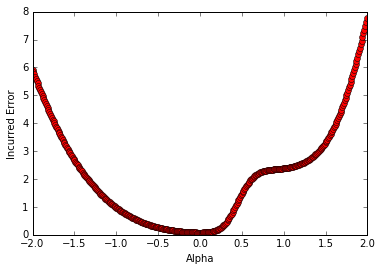

In [2]:
import matplotlib.pyplot as plt

summary_writer = tf.summary.FileWriter("linear_interp_logs/", graph=sess.graph)
summary_op = tf.summary.merge_all()
results = []
for a in np.arange(-2, 2, 0.01):
    feed_dict = {
        x: mnist.test.images,
        y: mnist.test.labels,
        alpha: [[a]],
    }

    cost, summary_str = sess.run([cost_inter, summary_op], feed_dict=feed_dict)
    summary_writer.add_summary(summary_str, (a + 2)/0.01)
    results.append(cost)

plt.plot(np.arange(-2, 2, 0.01), results, 'ro')
plt.ylabel('Incurred Error')
plt.xlabel('Alpha')
plt.show()

The cost function of a three-layer feed-forward network as we linearly interpolate on the line connecting a randomly initialized parameter vector and an SGD solution

## Flat Regions in the Error Surface
More generally, given an arbitrary function, a point at which the gradient is the zero vector is called a `critical point`.

For a one-dimensional cost function, a critical point can take one of three forms, as shown in Figure 4-4.

![4-4](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0404.png)

Figure 4-4. Analyzing a critical point along a single dimension

This means given a random critical point in a random one-dimensional function, it has one-third probability of being a local minimum. This means that if we have a total of k critical points, we can expect to have a total of $\frac{k}{3}$  local minima.

We can also extend this to higher dimensional functions. Consider a cost function operating in a d-dimensional space. 

![4-5](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0405.png)

Figure 4-5. A saddle point over a two-dimensional error surface

In general, in a d-dimensional parameter space, we can slice through a critical point on d different axes. **A critical point can only be a local minimum if it appears as a local minimum in every single one of the d one-dimensional subspaces.** Using the fact that a critical point can come in one of three different flavors(local minima,local maxima and saddle points) in a one-dimensional subspace, we realize that the probability that a random critical point is in a random function is $\frac{1}{3^d}$. This means that a random function function with k critical points has an expected number of $\frac{k}{3^d}$ local minima. In other words, **as the dimensionality of our parameter space increases, local minima become exponentially more rare.**

It seems **like these flat segments of the error surface are pesky but ultimately don’t prevent stochastic gradient descent from converging to a good answer.** However, it does pose serious problems for methods that attempt to directly solve for a point where the gradient is zero. 

## When the Gradient Points in the Wrong Direction
As an example, we consider an error surface defined over a two-dimensional parameter space, as shown in Figure 4-6.

![4-6](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0406.png)

Figure 4-6. Local information encoded by the gradient usually does not corroborate the global structure of the error surface

Specifically, we realize that only when the contours are perfectly circular does the gradient always point in the direction of the local minimum. However, if the contours are extremely elliptical (as is usually the case for the error surfaces of deep networks), the gradient can be as inaccurate as 90 degrees away from the correct direction!

The general problem with taking a significant step in this direction, however, is that the gradient could be changing under our feet as we move! We demonstrate this simple fact in Figure 4-7. Going back to the two-dimensional example, if our contours are perfectly circular and we take a big step in the direction of the steepest descent, the gradient doesn’t change direction as we move. However, this is not the case for highly elliptical contours.

![4-7](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0407.png)

Figure 4-7. We show how the direction of the gradient changes as we move along the direction of steepest descent (as determined from a starting point). The gradient vectors are normalized to identical length to emphasize the change in direction of the gradient vector. 

More generally, we can quantify how the gradient changes under our feet as we move in a certain direction by computing second derivatives. Specifically, we want to measure $\frac{\partial(\partial E / \partial w_j)}{\partial w_j}$, which tells us how the gradient component for $w_j$ changes as we change the value of $w_i$. We can compile this information into a special matrix known as the `Hessian matrix` (H). And when describing an error surface where the gradient changes underneath our feet as we move in the direction of steepest descent, this matrix is said to be `ill-conditioned`.

We can now use a second-order approximation via Taylor series:

$$E(x) \approx E(x^{(i)}) + (x-x^{(i)})^T g + \frac{1}{2} (x-x^{(i)})^T H (x-x^{(i)})$$

If we go further to state that we will be moving $\epsilon$ units in the direction of the gradient, we can further simplify our expression:

$$E(x^{(i)} - \epsilon g) \approx E(x^{(i)}) - \epsilon g^T g + \frac{1}{2}\epsilon^2 g^THg$$

This expression consists of three terms: 

1. the value of the error function at the original parameter vector, 
1. the improvement in error afforded by the magnitude of the gradient, 
1. a correction term that incorporates the curvature of the surface as represented by the Hessian matrix.

## Momentum-Based Optimization
Fundamentally, **the problem of an ill-conditioned Hessian matrix manifests itself in the form of gradients that fluctuate wildly.** As a result, one popular mechanism for dealing with ill-conditioning bypasses the computation of the Hessian, and instead, focuses on how to cancel out these fluctuations over the duration of training.

Our goal, then, is to somehow generate an analog for velocity in our optimization algorithm. We can do this by keeping track of an exponentially weighted decay of past gradients. The premise is simple: every update is computed by combining the update in the last iteration with the current gradient. Concretely, we compute the change in the parameter vector as follows:

$$v_i = mv_{i-1} - \epsilon g_i$$

$$\theta_i = \theta_{i-1} + v_i$$

In other words, we use the  momentum hyperparameter m to determine what fraction of the previous velocity to retain in the new update, and add this “memory” of past gradients to our current gradient. This approach is commonly referred to as `momentum`.

To better visualize how momentum works, we’ll explore a toy example. Specifically, we’ll investigate how momentum affects updates during a `random walk`. A random walk is a succession of randomly chosen steps. In our example, we’ll imagine a particle on a line that, at every time interval, randomly picks a step size between -10 and 10 and takes a moves in that direction. This is simply expressed as:

```py
step_range = 10
step_choices = range(-1 * step_range, step_range + 1)
rand_walk = [random.choice(step_choices) for x in xrange(100)]
```

We’ll then simulate what happens when we use a slight modification of momentum (i.e., the standard exponentially weighted moving average algorithm) to smooth our choice of step at every time interval. Again, we can concisely express this as:

```py
momentum_rand_walk = [random.choice(step_choices)]
for i in xrange(len(rand_walk) - 1):
    prev = momentum_rand_walk[-1]
    rand_choice = random.choice(step_choices)
    new_step = momentum * prev + (1 - momentum) * rand_choice
    momentum_rand_walk.append()
```

![4-8](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0408.png)

Figure 4-8. Momentum smooths volatility in the step sizes during a random walk using an exponentially weighted moving average

The resulting speedup is staggering. We display how the cost function changes over time by comparing the TensorBoard visualizations in Figure 4-9. The figure demonstrates that to achieve a cost of 0.1 without momentum (right) requires nearly 18,000 steps (minibatches), whereas with momentum (left), we require just over 2,000.

![4-9](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0409.png)

Figure 4-9. Comparing training a feed-forward network with (right) and without (left) momentum demonstrates a massive decrease in training time

## A Brief View of Second-Order Methods
Several second-order methods, however, have been researched over the past several years that attempt to approximate the Hessian directly.

### Conjugate Gradient Descent
In steepest descent, we compute the direction of the gradient and then `line search` to find the minimum along that direction. We jump to the minimum and then recompute the gradient to determine the direction of the next line search. It turns out that this method ends up zigzagging a significant amount, as shown in Figure 4-9, because each time we move in the direction of steepest descent, we undo a little bit of progress in another direction. A remedy to this problem is moving in a `conjugate direction` relative to the previous choice instead of the direction of steepest descent. The conjugate direction is chosen by using an indirect approximation of the Hessian to linearly combine the gradient and our previous direction. With a slight modification, this method generalizes to the nonconvex error surfaces we find in deep networks.

![4-10](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0410.png)

Figure 4-10. The method of steepest descent often zigzags; conjugate descent attempts to remedy this issue

### Broyden–Fletcher–Goldfarb–Shanno (BFGS)
`BFGS` algorithm attempts to compute the inverse of the Hessian matrix iteratively and use the inverse Hessian to more effectively optimize the parameter vector. A more memory-efficient version known as `L-BFGS`.

## Learning Rate Adaptation
### AdaGrad—Accumulating Historical Gradients
This learning rate is inversely scaled with respect to the square root of the sum of the squares (root mean square) of all the parameter’s historical gradients.

Flat regions may force AdaGrad to decrease the learning rate before it reaches a minimum.

$$r_i=r_{i-1} + g_i \odot g_i$$

- $r_0=0$
- $\odot$ is element-wise tensor multiplication
- $g_i \odot g_i$ the square of all the gradient parameters

$$\theta_i = \theta_{i-1} - \frac{\epsilon}{\sigma \oplus \sqrt{r_i}} \odot g$$

- $\epsilon$ global learning rate, is divided by the square root of the gradient accumulation vector
- $\sigma(\approx 10^{-7})$ ,a tiny number in order to prevent division by zero

In TensorFlow, a built-in optimizer allows for easily utilizing AdaGrad as a learning algorithm:

```py
tf.train.AdagradOptimizer(learning_rate, 
                          initial_accumulator_value=0.1, 
                          use_locking=False, 
                          name='Adagrad')
```

- the $\epsilon$ and initial gradient accumulation vector are rolled together into the `initial_accumulator_value` argument

### RMSProp—Exponentially Weighted Moving Average of Gradients
$$r_i=\rho r_{i-1} + (1 - \rho) g_i \odot g_i$$

- $\rho$ the decay factor determines how long we keep old gradients

```py
tf.train.RMSPropOptimizer(learning_rate, decay=0.9, 
                          momentum=0.0, epsilon=1e-10, 
                          use_locking=False, name='RMSProp')
```

- Unlike in Adagrad, we pass in $\delta$ separately as the epsilon argument to the constructor.

### Adam—Combining Momentum and RMSProp
$$\tilde{m_i} = \frac{m_i}{1-\beta_1^i}$$

$$v_i=\frac{v_i}{1-\beta_2^i}$$

$$\theta_i=\theta_{i-1} - \frac{\epsilon}{\sigma \oplus \sqrt{v_i}\tilde{m_i}}$$

```py
tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, 
                       beta2=0.999, epsilon=1e-08, 
                       use_locking=False, name='Adam')
```


## Optimization Algorithms Experiment

In [4]:
!python optimzer_mlp.py sgd

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
sgd
2017-08-15 08:28:09.183430: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-15 08:28:09.183453: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-15 08:28:09.183459: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-08-15 08:28:09.183464: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these ar

In [5]:
!python optimzer_mlp.py momentum

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
momentum
2017-08-15 09:07:09.048477: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-15 09:07:09.048500: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-15 09:07:09.048506: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-08-15 09:07:09.048511: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but the